#IMDB Dataset Exploration

In [ ]:
nltk.download('punkt')

NameError: ignored

In [ ]:
!pip install ktrain

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
!pip install clean-text

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
import ktrain
from ktrain import text
import pandas as pd
from sklearn.model_selection import train_test_split
import numpy as np
import string
import re
from cleantext import clean

import torch
from transformers.file_utils import is_tf_available, is_torch_available, is_torch_tpu_available
from transformers import BertTokenizerFast, BertForSequenceClassification
from transformers import Trainer, TrainingArguments

import nltk
# nltk.download('stopwords')
import string
from nltk.tokenize import word_tokenize

from nltk.corpus import stopwords
sw = set(stopwords.words('english'))

import os
os.environ["CUDA_DEVICE_ORDER"]="PCI_BUS_ID";
os.environ["CUDA_VISIBLE_DEVICES"]="0"; 

Since the GPL-licensed package `unidecode` is not installed, using Python's `unicodedata` package which yields worse results.


In [ ]:
import pandas as pd
df = pd.read_csv("/content/drive/MyDrive/Comp. Sci. Lab Course/IMDB Dataset.csv")

In [ ]:
df.head()

,review,sentiment
0,One of the other reviewers has mentioned that ...,positive
1,A wonderful little production. <br /><br />The...,positive
2,I thought this was a wonderful way to spend ti...,positive
3,Basically there's a family where a little boy ...,negative
4,"Petter Mattei's ""Love in the Time of Money"" is...",positive


In [ ]:
cleaned_df = []

for i in df["review"]:
    i = clean(i,no_urls=True, replace_with_url="", no_digits=True,
              replace_with_digit="",fix_unicode = True, lower = True)
    
    cleaned_df.append(i)
  


In [ ]:
cleaned_df[:2]

["one of the other reviewers has mentioned that after watching just oz episode you'll be hooked. they are right, as this is exactly what happened with me.<br /><br />the first thing that struck me about oz was its brutality and unflinching scenes of violence, which set in right from the word go. trust me, this is not a show for the faint hearted or timid. this show pulls no punches with regards to drugs, sex or violence. its is hardcore, in the classic use of the word.<br /><br />it is called oz as that is the nickname given to the oswald maximum security state penitentary. it focuses mainly on emerald city, an experimental section of the prison where all the cells have glass fronts and face inwards, so privacy is not high on the agenda. em city is home to many..aryans, muslims, gangstas, latinos, christians, italians, irish and more....so scuffles, death stares, dodgy dealings and shady agreements are never far away.<br /><br />i would say the main appeal of the show is due to the fac

In [ ]:
def remove_html_markup(s):
    tag = False
    quote = False
    out = ""

    for c in s:
            if c == '<' and not quote:
                tag = True
            elif c == '>' and not quote:
                tag = False
            elif (c == '"' or c == "'") and tag:
                quote = not quote
            elif not tag:
                out = out + c

    return out

In [ ]:
cleaned_df2 = []

for i, _ in enumerate(cleaned_df):
    cleanedtemp = remove_html_markup(cleaned_df[i])
    cleaned_df2.append(cleanedtemp)
  
cleaned_df2[0]

"one of the other reviewers has mentioned that after watching just oz episode you'll be hooked. they are right, as this is exactly what happened with me.the first thing that struck me about oz was its brutality and unflinching scenes of violence, which set in right from the word go. trust me, this is not a show for the faint hearted or timid. this show pulls no punches with regards to drugs, sex or violence. its is hardcore, in the classic use of the word.it is called oz as that is the nickname given to the oswald maximum security state penitentary. it focuses mainly on emerald city, an experimental section of the prison where all the cells have glass fronts and face inwards, so privacy is not high on the agenda. em city is home to many..aryans, muslims, gangstas, latinos, christians, italians, irish and more....so scuffles, death stares, dodgy dealings and shady agreements are never far away.i would say the main appeal of the show is due to the fact that it goes where other shows woul

In [ ]:
finalText= []
for i in cleaned_df2:
    tokens = word_tokenize(i)
    table = str.maketrans('','',string.punctuation)
    stripped = [w.translate(table) for w in tokens]

    words = [word for word in stripped if word.isalpha()]
    words = [w for w in words if not w in sw]
    s = " "
    temp = s.join(words)
    finalText.append(temp)

In [ ]:
df["cleaned"] = finalText
df['sentiment'] = df['sentiment'].astype('str') 
df['sentiment'][df['sentiment']=='positive'] = 1
df['sentiment'][df['sentiment']=='negative'] = 0
df.head()

,review,sentiment,cleaned
0,One of the other reviewers has mentioned that ...,1,one reviewers mentioned watching oz episode ho...
1,A wonderful little production. <br /><br />The...,1,wonderful little production filming technique ...
2,I thought this was a wonderful way to spend ti...,1,thought wonderful way spend time hot summer we...
3,Basically there's a family where a little boy ...,0,basically family little boy jake thinks zombie...
4,"Petter Mattei's ""Love in the Time of Money"" is...",1,petter mattei love time money visually stunnin...


In [ ]:
df['sentiment'] = df['sentiment'].astype('category') 
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 50000 entries, 0 to 49999
Data columns (total 3 columns):
 #   Column     Non-Null Count  Dtype   
---  ------     --------------  -----   
 0   review     50000 non-null  object  
 1   sentiment  50000 non-null  category
 2   cleaned    50000 non-null  object  
dtypes: category(1), object(2)
memory usage: 830.3+ KB


In [ ]:
df['sentiment'].value_counts()

0    25000
1    25000
Name: sentiment, dtype: int64

In [ ]:
from random import sample
sample(range(0,50000), 10)

[48367, 38999, 9122, 31882, 4055, 7552, 45718, 24683, 8970, 26874]

In [ ]:
randomsampleSet = sample(range(0,50000),1000)
x = df["cleaned"].values[randomsampleSet]
y = df["sentiment"].astype('str').values[randomsampleSet]

x_train, x_test, y_train, y_test = train_test_split(x, y, test_size = 0.3, random_state = 10)

In [ ]:
MODEL_NAME = 'distilbert-base-uncased-distilled-squad'
t = text.Transformer(MODEL_NAME, maxlen=500, class_names=[0,1])

In [ ]:
trn = t.preprocess_train(x_train, y_train)
val = t.preprocess_test(x_test, y_test)
model = t.get_classifier()
learner = ktrain.get_learner(model, train_data=trn, val_data=val, batch_size=10)

preprocessing train...
language: en
train sequence lengths:
	mean : 118
	95percentile : 304
	99percentile : 472


/usr/local/lib/python3.7/dist-packages/ktrain/utils.py:738: UserWarning: class_names argument was ignored, as they were extracted from string labels in dataset
  "class_names argument was ignored, as they were extracted from string labels in dataset"


Is Multi-Label? False
preprocessing test...
language: en
test sequence lengths:
	mean : 115
	95percentile : 282
	99percentile : 345


In [ ]:
trn.x

array([[[  101,  3773,  3538, ...,     0,     0,     0],
        [    1,     1,     1, ...,     0,     0,     0],
        [    0,     0,     0, ...,     0,     0,     0]],

       [[  101,  2442, 18443, ...,     0,     0,     0],
        [    1,     1,     1, ...,     0,     0,     0],
        [    0,     0,     0, ...,     0,     0,     0]],

       [[  101,  2583,  6865, ...,     0,     0,     0],
        [    1,     1,     1, ...,     0,     0,     0],
        [    0,     0,     0, ...,     0,     0,     0]],

       ...,

       [[  101,  2293,  3185, ...,     0,     0,     0],
        [    1,     1,     1, ...,     0,     0,     0],
        [    0,     0,     0, ...,     0,     0,     0]],

       [[  101,  2387,  3185, ...,     0,     0,     0],
        [    1,     1,     1, ...,     0,     0,     0],
        [    0,     0,     0, ...,     0,     0,     0]],

       [[  101,  2051,  3698, ..., 10760,  2051,   102],
        [    1,     1,     1, ...,     1,     1,     1],
        

simulating training for different learning rates... this may take a few moments...
Epoch 1/2
70/70 [==============================] - 48s 545ms/step - loss: 0.7081 - accuracy: 0.4900
Epoch 2/2
70/70 [==============================] - 27s 379ms/step - loss: 38.4423 - accuracy: 0.4851


done.
Visually inspect loss plot and select learning rate associated with falling loss


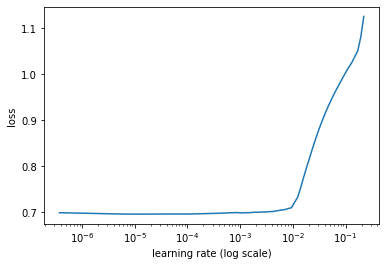

In [ ]:
learner.lr_find(show_plot=True, max_epochs=2)

In [ ]:
learner.fit_onecycle(3e-5, 5)




begin training using onecycle policy with max lr of 3e-05...
Epoch 1/5
70/70 [==============================] - 54s 677ms/step - loss: 0.6943 - accuracy: 0.4857 - val_loss: 0.6763 - val_accuracy: 0.5300
Epoch 2/5
70/70 [==============================] - 45s 643ms/step - loss: 0.5822 - accuracy: 0.6957 - val_loss: 0.4484 - val_accuracy: 0.8100
Epoch 3/5
70/70 [==============================] - 45s 647ms/step - loss: 0.3460 - accuracy: 0.8586 - val_loss: 0.4586 - val_accuracy: 0.8267
Epoch 4/5
70/70 [==============================] - 45s 643ms/step - loss: 0.1798 - accuracy: 0.9386 - val_loss: 0.4336 - val_accuracy: 0.8533
Epoch 5/5
70/70 [==============================] - 45s 645ms/step - loss: 0.0565 - accuracy: 0.9886 - val_loss: 0.4889 - val_accuracy: 0.8300


NameError: ignored

In [ ]:
predictor = ktrain.get_predictor(learner.model, preproc=t)
predictor.save('myModel')

In [33]:
testRandom = sample(range(0,50000),100)
testSet = list(df["cleaned"][testRandom])
actuals = df['sentiment'].astype('str').values[testRandom]
predictions = predictor.predict(testSet)

myTestSet = pd.DataFrame({'Data': testSet, 'Actual': actuals, 'Predictions': predictions})
pd.crosstab(myTestSet["Actual"],myTestSet["Predictions"] )

Predictions,0,1
Actual,,
0,46,0
1,7,47


In [ ]:
predictor.save('myModel')

#Reload a Saved Model

In [34]:
# import pickle
# from tensorflow.keras.models import load_model
# # loading preprocess and model file
# features = pickle.load(open('/content/myModel/tf_model.preproc',
#                             'rb'))
# new_model = load_model('/content/myModel/tf_model.h5')
# labels = [0, 1]

# text = 'one of the other reviewers has mentioned that after watching just oz episode you'll be hooked. they are right, as this is exactly what happened with me.<br /><br />the first thing that struck me about oz was its brutality and unflinching scenes of violence, which set in right from the word go. trust me, this is not a show for the faint hearted or timid. this show pulls no punches with regards to drugs, sex or violence. its is hardcore, in the classic use of the word.<br /><br />it is called oz as that is the nickname given to the oswald maximum security state penitentary. it focuses mainly on emerald city, an experimental section of the prison where all the cells have glass fronts and face inwards, so privacy is not high on the agenda. em city is home to many..aryans, muslims, gangstas, latinos, christians, italians, irish and more....so scuffles, death stares, dodgy dealings and shady agreements are never far away.'
# preproc_text = features.preprocess([text])
# result = new_model.predict(preproc_text)

In [35]:
predictor = ktrain.load_predictor('myModel')

prediction = predictor.predict(testSet[10])
print(prediction)

1


In [36]:
randomsampleSet = sample(range(0,50000),10)

predictions = predictor.predict(df["cleaned"].values[randomsampleSet])

output = pd.DataFrame({'Text': df["cleaned"].values[randomsampleSet], 'Predictions':predictions })

output

,Text,Predictions
0,two terrorist attacks europe one london amster...,0
1,directed written famousinfamous edward wood jr...,0
2,spoilers simple movie simple people problems f...,1
3,nt pretend authority actors played othello nev...,1
4,ted v mikels film corpse grinders minutes excr...,0
5,future society military component recruit rath...,1
6,airwolf movie variation original part pilot ye...,1
7,opportunity see last evening local film festiv...,1
8,alain delon visits swift sure vengeance ruthle...,1
9,acting film really well done honestly movie sl...,0
